In [1]:
!pip install matplotlib --upgrade
!pip install Pillow --upgrade

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow import keras

In [3]:
data_dir = 'data/kvasirv2'

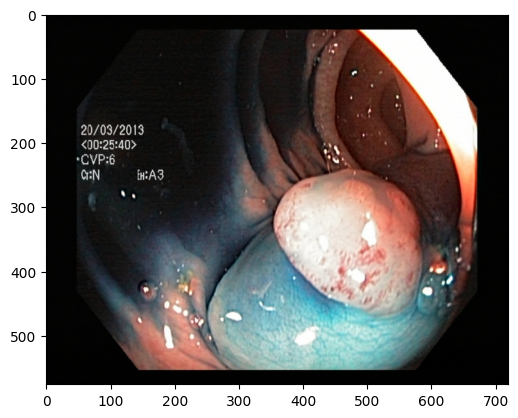

In [4]:
import cv2

test = cv2.imread('data/kvasirv2/dyed-lifted-polyps/0a42cb65-e906-46b3-936a-f5f1dc71f108.jpg')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test)

In [5]:
test.shape

(576, 720, 3)

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory
image_height = 256
image_width = 256
batch_size = 32
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 3,
    image_size = (image_height, image_width),
    batch_size = batch_size)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.


In [7]:
class_names = train_ds.class_names
len(class_names)

8

In [8]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
validation_ds = image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 3,
    image_size = (image_height, image_width),
    batch_size = batch_size)

Found 8000 files belonging to 8 classes.
Using 1600 files for validation.


In [10]:
from keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, Activation

polypnet_model = Sequential()
pretrained_model = ResNet50(include_top = False, input_shape = (256,256,3), pooling = 'avg', classes = 8, weights = 'imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False

polypnet_model.add(pretrained_model)
polypnet_model.add(Flatten())
polypnet_model.add(Dense(512, activation = 'relu'))
polypnet_model.add(Dense(8, activation = 'softmax'))

In [11]:
from keras.optimizers import Adam
polypnet_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [12]:
polypnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24640904 (94.00 MB)
Trainable params: 1053192 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [13]:
epochs = 10
history = polypnet_model.fit(train_ds, validation_data = validation_ds, epochs = epochs)

Epoch 1/10
200/200 [==============================] - 260s 1s/step - loss: 0.6216 - accuracy: 0.7823 - val_loss: 0.4578 - val_accuracy: 0.8275
Epoch 2/10
200/200 [==============================] - 281s 1s/step - loss: 0.3480 - accuracy: 0.8634 - val_loss: 0.3833 - val_accuracy: 0.8531
Epoch 3/10
200/200 [==============================] - 287s 1s/step - loss: 0.2844 - accuracy: 0.8948 - val_loss: 0.3395 - val_accuracy: 0.8687
Epoch 4/10
200/200 [==============================] - 290s 1s/step - loss: 0.2527 - accuracy: 0.9053 - val_loss: 0.3452 - val_accuracy: 0.8681
Epoch 5/10
200/200 [==============================] - 304s 2s/step - loss: 0.2237 - accuracy: 0.9162 - val_loss: 0.3164 - val_accuracy: 0.8756
Epoch 6/10
200/200 [==============================] - 309s 2s/step - loss: 0.2002 - accuracy: 0.9262 - val_loss: 0.3163 - val_accuracy: 0.8725
Epoch 7/10
200/200 [==============================] - 296s 1s/step - loss: 0.1822 - accuracy: 0.9328 - val_loss: 0.3137 - val_accuracy: 0.8781

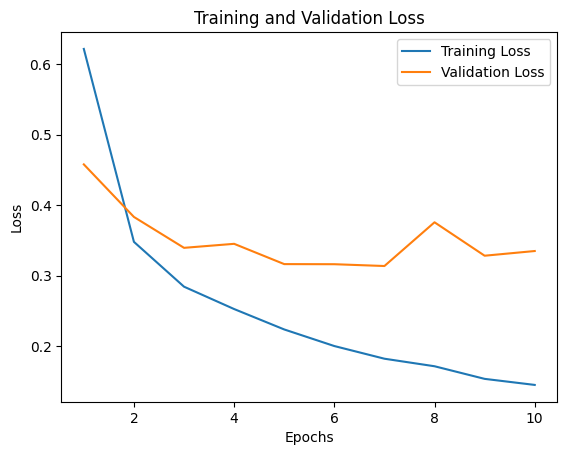

In [14]:
t_loss = history.history['loss']
v_loss = history.history['val_loss']
t_acc = history.history['accuracy']
v_acc = history.history['val_accuracy']

epochs_range = range(1, len(t_loss) + 1)

plt.plot(epochs_range,t_loss, label = 'Training Loss')
plt.plot(epochs_range, v_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

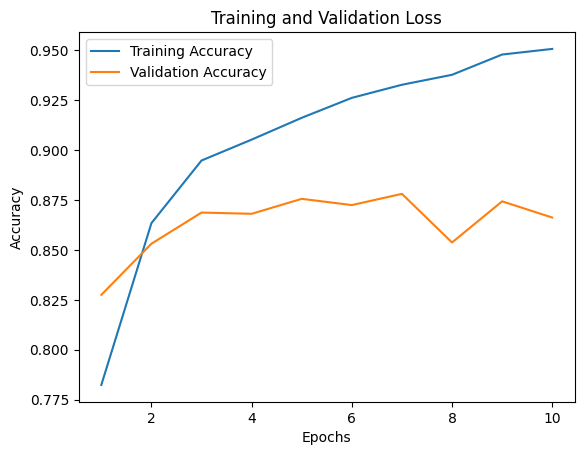

In [15]:
t_loss = history.history['loss']
v_loss = history.history['val_loss']
t_acc = history.history['accuracy']
v_acc = history.history['val_accuracy']

epochs_range = range(1, len(t_loss) + 1)

plt.plot(epochs_range,t_acc, label = 'Training Accuracy')
plt.plot(epochs_range, v_acc, label = 'Validation Accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
polypnet_model.save('polypnet_model_updated.h5')

C:\Users\91923\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 74ms/step
normal-z-line


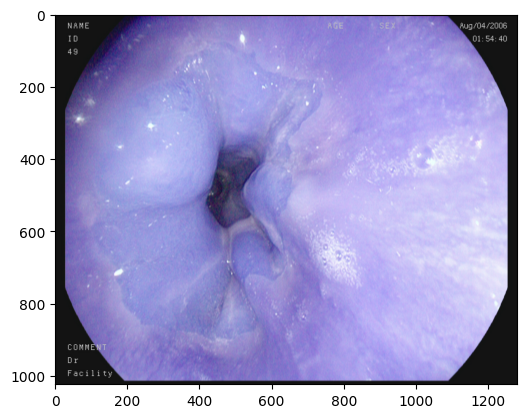

In [18]:
test_path = 'data/kvasirv2/normal-z-line/0e9f4a61-cb48-42bd-adfd-0c5bd6c8e313.jpg'
test_image = cv2.imread(test_path)
plt.imshow(test_image)
image_resized = cv2.resize(test_image, (256, 256))
test_image = np.expand_dims(image_resized, axis=0)
predictions = polypnet_model.predict(test_image)
output = class_names[np.argmax(predictions)]
print(output)

In [19]:
def test(path):
    test_path = path
    test_image = cv2.imread(test_path)
    plt.imshow(test_image)
    image_resized = cv2.resize(test_image, (256, 256))
    test_image = np.expand_dims(image_resized, axis=0)
    predictions = polypnet_model.predict(test_image)
    output = class_names[np.argmax(predictions)]
    print(output)


1/1 [==============================] - 0s 73ms/step
dyed-lifted-polyps


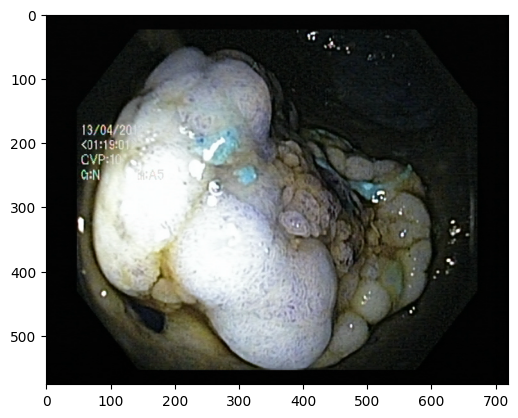

In [20]:
test('dataset/kvasirv2/train/dyed-lifted-polyps/00cf9508-6ad1-4db9-840a-519c1d515c30.jpg')

In [49]:
!pip install pyqt5

In [ ]:
import sys
import os
from PyQt5.QtWidgets import QApplication, QMainWindow, QWidget, QVBoxLayout, QLabel, QPushButton, QFileDialog, QTabWidget, QListWidget, QListWidgetItem, QHBoxLayout
from PyQt5.QtGui import QPixmap, QImage
from PyQt5.QtCore import Qt
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

class ImageClassifierApp(QMainWindow):
    def __init__(self):
        super().__init__()

        self.setWindowTitle("Image Classifier")
        self.setGeometry(100, 100, 800, 600)

        self.class_names = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']  # Replace with your actual class names

        self.model = load_model('polypnet_model.h5')

        self.initUI()

    def initUI(self):
        self.tabs = QTabWidget()
        self.setCentralWidget(self.tabs)

        self.classify_tab = QWidget()
        self.history_tab = QWidget()

        self.tabs.addTab(self.classify_tab, "Classify")
        self.tabs.addTab(self.history_tab, "History")

        self.initClassifyTab()
        self.initHistoryTab()

    def initClassifyTab(self):
        layout = QVBoxLayout()

        self.image_label = QLabel("No image selected")
        self.image_label.setAlignment(Qt.AlignCenter)
        layout.addWidget(self.image_label)

        self.result_label = QLabel("")
        self.result_label.setAlignment(Qt.AlignCenter)
        layout.addWidget(self.result_label)

        self.select_button = QPushButton("Select Image")
        self.select_button.clicked.connect(self.openImage)
        layout.addWidget(self.select_button)

        self.classify_tab.setLayout(layout)

    def initHistoryTab(self):
        layout = QVBoxLayout()

        self.history_list = QListWidget()
        layout.addWidget(self.history_list)

        self.history_tab.setLayout(layout)

    def openImage(self):
        options = QFileDialog.Options()
        file_name, _ = QFileDialog.getOpenFileName(self, "Select Image", "", "Images (*.png *.xpm *.jpg *.bmp *.gif);;All Files (*)", options=options)
        if file_name:
            self.displayImage(file_name)
            self.classifyImage(file_name)

    def displayImage(self, file_path):
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, ch = image.shape
        bytes_per_line = ch * w
        convert_to_qt_format = QImage(image.data, w, h, bytes_per_line, QImage.Format_RGB888)
        pixmap = QPixmap.fromImage(convert_to_qt_format)
        self.image_label.setPixmap(pixmap.scaled(self.image_label.size(), Qt.KeepAspectRatio))

    def classifyImage(self, file_path):
        test_image = cv2.imread(file_path)
        image_resized = cv2.resize(test_image, (256, 256))
        test_image = np.expand_dims(image_resized, axis=0)

        predictions = self.model.predict(test_image)
        output_class = self.class_names[np.argmax(predictions)]

        self.result_label.setText(f"Class: {output_class}, Confidence: {np.max(predictions):.2f}")

        self.addToHistory(file_path, output_class, np.max(predictions))

    def addToHistory(self, file_path, output_class, confidence):
        history_item_widget = QWidget()
        layout = QHBoxLayout()

        image_label = QLabel()
        pixmap = QPixmap(file_path)
        image_label.setPixmap(pixmap.scaled(100, 100, Qt.KeepAspectRatio))
        layout.addWidget(image_label)

        text_label = QLabel(f"Class: {output_class}, Confidence: {confidence:.2f}")
        layout.addWidget(text_label)

        history_item_widget.setLayout(layout)
        list_item = QListWidgetItem()
        list_item.setSizeHint(history_item_widget.sizeHint())

        self.history_list.addItem(list_item)
        self.history_list.setItemWidget(list_item, history_item_widget)

if __name__ == "__main__":
    app = QApplication(sys.argv)
    window = ImageClassifierApp()
    window.show()
    sys.exit(app.exec_())


1/1 [==============================] - 0s 76ms/step


In [21]:
import sys
import tensorflow as tf
import keras

print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)



Python version: 3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.14.0
Keras version: 2.14.0


In [22]:
import numpy as np
print(np.__version__)

1.24.3
